# Using LDA for Topic Modeling

Add LDA description here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer


## Load Data

In [2]:
# load cleaned and preprocessed data
data = pd.read_csv('../data/cleaned_data/cleaned_processed_data.csv')
data.head()

,Content,ID
0,congressional republican new fear come health ...,0
1,bullet shell get counted blood dry votive cand...,1
2,walt disney bambi opened critic praised spare ...,2
3,death may great equalizer isnt necessarily eve...,3
4,north korea leader kim said sunday country mak...,4


## Additional Cleaning

Further cleaning is necessary to come up with better results in choosing topics.

In [3]:
# remove rows containg NaN value

nan_in_context = data['Content'].isna()
num_nans = data['Content'].isna().sum()
print(num_nans)

if num_nans > 0:
    data.dropna(subset=['Content'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['ID'] = range(len(data))

data

0


,Content,ID
0,congressional republican new fear come health ...,0
1,bullet shell get counted blood dry votive cand...,1
2,walt disney bambi opened critic praised spare ...,2
3,death may great equalizer isnt necessarily eve...,3
4,north korea leader kim said sunday country mak...,4
...,...,...
148866,program beat dialler scam introducing two init...,148866
148867,spam email tempt net shopper computer user acr...,148867
148868,careful code new european directive could put ...,148868
148869,cyber security chief resigns man making sure c...,148869


In [4]:
# observed that '_' was not removed. Further cleaning process
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations
    text = re.sub(r'_', '', text)
    ## Experiment

    words_to_remove = ["trump", "clinton", "donald"]
    text = ' '.join(word for word in text.split() if word not in words_to_remove)
    
    return text

data['Content'] = data['Content'].apply(clean_text)


## Using TF-IDF scores and Gensim's dictionary to further preprocess the data

In [5]:
import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [6]:
noBelow = len(data) * 0.001
noAbove = 0.4

In [7]:
# Using TF-IDF scores and gensim's Dictionary to further preprocess the data

corpus = data['Content'].tolist()
tokenized_docs = [article.split() for article in corpus]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# This returns words in the order they appear in the tfidf_matrix
feature_names = tfidf_vectorizer.get_feature_names_out()

# Take the maximum TF-IDF score across all documents for each word to identify the
# hightest importance that each word has in any single document.
tfidf_scores = tfidf_matrix.max(axis=0).toarray()[0]

# experimenting with threshold values.
threshold = np.mean(tfidf_scores)

word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

filtered_tokenized_docs = []
for doc in tokenized_docs:
    # filter out using TF-IDF threshold
    filtered_doc = [word for word in doc if word_tfidf_dict.get(word, 0) >= threshold]
    filtered_tokenized_docs.append(filtered_doc)

# Here, we use gensim's Dictionary to filter out extremes.
# According to ChatGPT, it calculates the document frequency for each word, and use that to filter out extremes.
tokenized_docs = filtered_tokenized_docs
dictionary = Dictionary(tokenized_docs)


dictionary.filter_extremes(no_below= noBelow, no_above= noAbove, keep_n=100000)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_docs]

## Finding the optimal number of topics using coherence score

In [10]:
# compute coherence score using C_v to find opt number of topics.

topic = []
score = []

# to choose opt number of topics, I ran from 1 ~ 10 number of topics to compare coherence score.
# There are many ways to calculate coherence score, but I chose to go with the most genearlized one, which is c_v score.
# I put number of workers same as the number of cores for my device.
# I read few articles, and learned that c_v score of 0.5 is good.
for i in tqdm(range(1,12)):
    lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                        iterations=10, num_topics=i, workers=8, passes=10, chunksize=1000,random_state=100)
    cm = CoherenceModel(model=lda_model, texts=tokenized_docs,
                       corpus=doc_term_matrix, coherence='c_v')
    topic.append(i)
    score.append(cm.get_coherence())


100%|██████████| 11/11 [30:34<00:00, 166.75s/it]


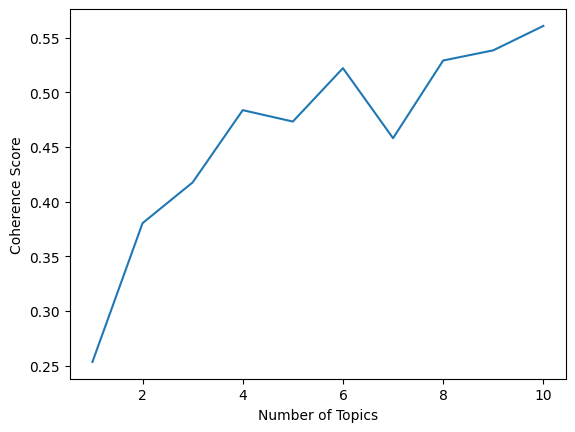

In [9]:
plt.plot(topic, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

## LDA Model

In [74]:
lda_model_opt = LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                        iterations=50, num_topics=11, workers=8, passes=50, random_state=100)



lda_model_opt.print_topics(-1)

[(0,
  '0.016*"court" + 0.013*"law" + 0.011*"school" + 0.010*"student" + 0.008*"case" + 0.007*"woman" + 0.007*"right" + 0.007*"federal" + 0.006*"justice" + 0.006*"judge"'),
 (1,
  '0.019*"police" + 0.009*"officer" + 0.007*"told" + 0.006*"gun" + 0.006*"city" + 0.005*"man" + 0.005*"death" + 0.005*"family" + 0.005*"according" + 0.005*"shooting"'),
 (2,
  '0.009*"country" + 0.008*"government" + 0.007*"united" + 0.007*"military" + 0.006*"war" + 0.006*"attack" + 0.006*"force" + 0.006*"china" + 0.006*"syria" + 0.005*"north"'),
 (3,
  '0.008*"american" + 0.007*"think" + 0.006*"political" + 0.006*"obama" + 0.005*"dont" + 0.005*"white" + 0.005*"america" + 0.005*"way" + 0.005*"country" + 0.005*"going"'),
 (4,
  '0.006*"woman" + 0.005*"life" + 0.005*"show" + 0.004*"get" + 0.004*"know" + 0.004*"thing" + 0.004*"way" + 0.003*"story" + 0.003*"dont" + 0.003*"family"'),
 (5,
  '0.014*"game" + 0.011*"team" + 0.009*"player" + 0.005*"sport" + 0.005*"world" + 0.005*"season" + 0.005*"win" + 0.005*"photo" + 0

In [43]:
lda_model_opt.save("lda_model_11")

## Visualize topics

Notice that the topic indices labeled above and the indices illustrated in the diagram below don't match.

We'll provide the list below to make it easier to follow along.
- Topic 0: 8
- Topic 1: 6
- Topic 2: 4
- Topic 3: 2
- Topic 4: 1
- Topic 5: 11
- Topic 6: 7
- Topic 7: 10
- Topic 8: 3
- Topic 9: 5
- Topic 10: 9


In [75]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_opt, doc_term_matrix, dictionary)
pyLDAvis.display(lda_display)

# Observing model output for each article

In [102]:
# Just wanted to check out if each topics made sense for certain readme files
n = 5
print(lda_model_opt[doc_term_matrix][n])
print(data['Content'].tolist()[n])

[(1, 0.22130466), (4, 0.07444883), (5, 0.57526606), (7, 0.120485865)]
queen elizabeth battling cold week missed new year day church service country estate sandringham buckingham palace said sunday week earlier queen missed christmas day church service first time since illness the queen yet feel ready attend church still recuperating heavy cold palace said statement queen husband prince philip also ill well enough attend service church sandringham norfolk east coast england queen ascended throne became world monarch following death king bhumibol adulyadej thailand october also britain monarch last year surpassed queen victoria reign mother lived age sick cold queen elizabeth miss new year service new york time


# Manually deciding topics based on topic modeling

After experimenting few times, we observed that topics 4 and 5 (illustrated as 1 and 11 in the diagram above), and 6 and 7 (illustrated as 7 and 10) are overalapping each other, which means 4,5 and 6,7 are pretty similar to each other. Also, if we look at the topic 4 (or 1 in the diagram), it is hard to come up with a legitimate topic using these words. Hence, we chose to combine topics 4 and 5 together, and 6 and 7 together. It makes sense to group these topics together because the topics are very relevant. We grouped 4 and 5 into 4, and 6 and 7 into 6.

In [83]:
topic_labels = {'Topic 0': 'Legal and Judicial Systems', 'Topic 1': 'Court cases and Crime',
                'Topic 2': 'International Affairs and Military', 'Topic 3': 'American Politics and Society', 
                'Topic 4': 'Entertainment and Sports', 'Topic 6': 'Health, Science, Environment, and Technology',
                'Topic 8': 'Business and Economy', 'Topic 9': 'Politics and Media',
                'Topic 10': 'Political Campaigns and Election'}

data['Topic'] = ''

# Assign Topic to each article

In [85]:
topics = []

for i in range(len(lda_model_opt[doc_term_matrix])):
    # topic_distribution = sorted(lda_model_opt[doc_term_matrix][i], key=lambda x: x[1], reverse=True)
    topic_distribution = lda_model_opt[doc_term_matrix][i]

    combined_score1 = sum(score for topic, score in topic_distribution if topic in [4, 5])
    combined_tuple1 = (4, combined_score1)
    combined_score2 = sum(score for topic, score in topic_distribution if topic in [6, 7])
    combined_tuple2 = (6, combined_score2)
        
    updated_topics = [t for t in topic_distribution if t[0] not in [4, 5, 6, 7]]
        
    updated_topics.append(combined_tuple1)
    updated_topics.append(combined_tuple2)

    updated_topics = sorted(updated_topics, key=lambda x: x[1], reverse=True)
    topic = topic_labels[f'Topic {updated_topics[0][0]}']
    topics.append(topic)
    

In [105]:
data['Topic'] = topics

data = data[['ID', 'Content', 'Topic']]

# Successfully assigned topics to each article

In [106]:
data[:10]

,ID,Content,Topic
0,0,congressional republican new fear come health ...,Legal and Judicial Systems
1,1,bullet shell get counted blood dry votive cand...,Court cases and Crime
2,2,walt disney bambi opened critic praised spare ...,Entertainment and Sports
3,3,death may great equalizer isnt necessarily eve...,Entertainment and Sports
4,4,north korea leader kim said sunday country mak...,International Affairs and Military
5,5,queen elizabeth battling cold week missed new ...,Entertainment and Sports
6,6,president tsai taiwan sharply criticized china...,International Affairs and Military
7,7,danny cahill stood slightly dazed blizzard con...,"Health, Science, Environment, and Technology"
8,8,hillary kerr founder digital medium company lo...,Entertainment and Sports
9,9,angel everywhere muñiz family apartment bronx ...,Entertainment and Sports


# Save it for article topic classification

In [108]:
data.to_csv('../data/articles_with_topics_assigned.csv', index=False)